In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import sys
import codecs
import mpld3

In [2]:
# initially we need document folders and document id's
path_to_dataset = '/home/madhi/Documents/python programs/neuralnetworks/fp/Reuters21578-Apte-115Cat/training'
folder_list = os.listdir(path_to_dataset)

In [3]:
#make a dictionary of document category and documents contain in the folder
cat_and_docs = [] #list
document_folder = [] #list
for docs_folder in folder_list:
    folder_path = path_to_dataset + "/" + docs_folder
    list_of_documents = os.listdir(folder_path)
    for real_docs in list_of_documents:
        document_folder.append(real_docs)
    #append folder_name and docs into the same list
    cat_and_docs.append((docs_folder,document_folder))
    #empty the document_folder list
    document_folder = []
    
print(cat_and_docs[1]) #the list is in format category and number of docs in that list

('palladium', ['0001792', '0001862'])


In [4]:
#make into dictionary
cate = [] 
documents = []

for category,docs in cat_and_docs:
    cate.append(category)
    documents.append(docs)
    
#convert into dictionary
total_dataset = dict(zip(cate,documents))

In [5]:
len(total_dataset)

116

In [36]:
feature_df = pd.read_csv('features_2.txt',sep=',')
feature_df.head()

,Document_id,Keywords
0,0,added oilseed processing mill standstill since...
1,0,march traded volumes uk grain potato futures f...
2,0,trades reported far us soymeal indicated uncha...
3,0,exported january european community countries ...
4,0,foreign meal users waiting expected surge ship...


In [7]:
doc_category = feature_df['Document_id']
features = feature_df['Keywords']
#convert into pandas Series
features_id = pd.Series(doc_category)
features_series = pd.Series(features)

print(features_id.shape,features_series.shape)

(11475,) (11475,)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
#in features_series list all features is considered as a single string
#we need to sepearate the words and have to apply tf-idf vectorizer and ngram to each words
def document_category(features_id):
    docs_category = []
    for ids in features_id:
        docs_category.append(ids)
    return docs_category

def separate_features_the_series(feature_series):
    main_feature_series = []
    features_stripped = []
    for features in feature_series:
        data_features = features.replace(","," ")
        main_feature_series.append(data_features)
    
    return main_feature_series

docs_id = document_category(features_id)
features_splitted = separate_features_the_series(features_series)
print(len(features_splitted))

11475


In [9]:
#tokenize and stem the words
import nltk
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [10]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    return filtered_tokens

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_df=1.0,max_features=10000,use_idf=True,tokenizer=tokenize_and_stem,ngram_range=(1,3))
%time  tfidf_matrix = tfidf_vectorizer.fit_transform(features_splitted)
print(tfidf_matrix.shape)

CPU times: user 50.1 s, sys: 240 ms, total: 50.3 s
Wall time: 50.5 s
(11475, 10000)


In [12]:
terms = tfidf_vectorizer.get_feature_names() #length is 10000

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

In [34]:
dist.shape

(11475, 11475)

In [14]:
len(cate)

116

In [15]:
len(documents)

116

In [54]:
from sklearn.externals import joblib
from sklearn.cluster import KMeans

num_clusters = 60
km = KMeans(n_clusters = num_clusters)

In [43]:
#decompose the tfidf_matrix (11475,10000) into (11475,500)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=500).fit_transform(tfidf_matrix) #array shape is(11475,500)

In [55]:
%time km.fit(svd)

CPU times: user 40.8 s, sys: 15.3 s, total: 56.1 s
Wall time: 35.9 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=60, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [56]:
%time joblib.dump(km,'clusters_2.pkl')

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 56 ms


['clusters_2.pkl']

In [57]:
#load the cluster
cl_load = joblib.load('clusters_2.pkl')
def_clusters = cl_load.labels_.tolist()
print(def_clusters[:96]) #just print to see the clusters

[42, 34, 44, 21, 44, 34, 48, 21, 21, 15, 21, 21, 9, 0, 25, 38, 36, 9, 25, 36, 25, 0, 44, 36, 10, 7, 44, 43, 28, 29, 43, 29, 9, 38, 25, 43, 36, 38, 28, 9, 10, 9, 9, 34, 38, 29, 9, 43, 9, 25, 25, 55, 8, 38, 34, 36, 25, 58, 9, 28, 9, 28, 25, 38, 25, 9, 25, 23, 11, 36, 38, 0, 36, 28, 36, 10, 44, 44, 9, 43, 11, 25, 7, 25, 25, 0, 0, 25, 10, 11, 23, 11, 9, 36, 25, 0]


In [58]:
#convert features_splitted into a Series Pandas
document = {'category':docs_id,'content':features_splitted ,'clusters':def_clusters}
frame = pd.DataFrame(document,index=[def_clusters],columns=['category','content','clusters'])

In [59]:
frame['clusters'].value_counts()

25    1467
44     941
35     825
21     507
58     492
4      454
29     453
46     366
36     360
22     326
9      307
30     305
3      263
8      217
45     201
52     185
57     175
18     150
10     149
59     140
6      134
0      133
17     132
55     128
16     124
51     122
56     118
13     116
38     113
7      113
48     112
19     111
41     108
12     104
31      99
49      97
14      88
43      86
28      85
15      82
42      78
5       78
26      74
34      69
33      66
20      61
2       60
11      59
40      50
53      50
54      48
50      44
39      42
37      41
24      36
47      34
1       31
27      22
32      22
23      22
Name: clusters, dtype: int64

In [60]:
frame.iloc[9658:9668] 

,category,content,clusters
25,87,mln dlrs hogan said systems provides integrate...,25
25,87,march vertex industries inc computer transceiv...,25
25,87,march renouf corp international said extended ...,25
25,87,company said acquisition still subject regulat...,25
19,87,group investment firms told securities exchang...,19
35,87,`` chrysler take renault stake american motors...,35
25,87,placed six mln dlrs order powercise internatio...,25
25,87,said book value unit mln dlrs teva said contin...,25
29,87,company said warrants exercisable five years p...,29
35,87,shr blah blah blah row gets bid harcourt brace...,35


In [61]:
grouped = frame['category'].groupby(frame['clusters'])
grouped.mean() 

clusters
0      6.496241
1     81.451613
2     55.100000
3     44.000000
4     46.964758
5     43.564103
6     44.000000
7     43.884956
8     48.769585
9      4.599349
10    26.751678
11     1.000000
12    44.000000
13    47.232759
14    44.000000
15    57.146341
16    44.000000
17    60.333333
18    35.666667
19    87.000000
20    32.885246
21    66.536489
22    60.843558
23     2.954545
24    69.861111
25    59.993865
26    58.216216
27    44.000000
28     4.035294
29    69.273731
30    44.000000
31    72.121212
32    54.500000
33    45.939394
34    50.463768
35    49.591515
36    18.422222
37    36.560976
38     1.000000
39    96.023810
40    44.000000
41    44.000000
42    49.628205
43     1.000000
44    46.741764
45    44.427861
46    49.587432
47    52.411765
48    65.196429
49    44.000000
50    44.000000
51    44.000000
52    44.000000
53    45.600000
54    40.937500
55    51.359375
56    24.500000
57    59.588571
58    74.750000
59    44.000000
Name: category, dtype: float64

In [62]:
#convert document into series
series_docs = pd.Series(documents)
individual_docs = [] #to store individual documents
for document in series_docs:
    for indi_docs in document:
        individual_docs.append(indi_docs)

individual_docs.pop()
print(len(individual_docs))

11476


In [63]:
series_indi_docs = pd.Series(individual_docs)
series_indi_docs = series_indi_docs[:-1]
print(series_indi_docs.shape) #the shape of frame is (11475,4)

(11475,)


In [64]:
frame.head()

,category,content,clusters
42,0,added oilseed processing mill standstill since...,42
34,0,march traded volumes uk grain potato futures f...,34
44,0,trades reported far us soymeal indicated uncha...,44
21,0,exported january european community countries ...,21
44,0,foreign meal users waiting expected surge ship...,44


In [65]:
frame['document'] = series_indi_docs.values
frame.iloc[6000:6010]

,category,content,clusters,document
13,44,ntt said business operations plan submitted po...,13,0003569
7,44,company said uk agribusiness group reported ex...,7,0008869
12,44,tax rate pct vs pct due impact tax reform act ...,12,0003770
35,44,yr net blah blah blah sees higher st qtr `` am...,35,0007668
45,44,march excel bancorp inc said board declared in...,45,0005203
52,44,revs mln vs mln year shr dlrs vs dlrs net mln ...,52,0001490
30,44,vs given revs mln vs given march shr cts vs g...,30,0008716
30,44,`` kiena gold mines ltd th qtr net toronto yea...,30,0008699
41,44,net includes mln dlr asset writedown mln dlr r...,41,0008809
59,44,cts prior pay april record april six restaura...,59,0001533


In [66]:
#tp store the dataFrame as  csv file for future prediction
frame.to_csv('document_clustered_2.csv',sep=",",index=None)

In [67]:
document_content = frame['content']
stopwords = nltk.corpus.stopwords.words('english')

In [69]:
totalvocab_stemmed = []
totalvocab_tokenized = []
count=1
for i in document_content:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.append(allwords_stemmed)
    
    allwords_tokens = tokenize_only(i)
    totalvocab_tokenized.append(allwords_tokens)
    if count % 1000 == 0:
        print("Finished {} documents".format(count))
    count += 1 #increment the count

Finished 1000 documents
Finished 2000 documents
Finished 3000 documents
Finished 4000 documents
Finished 5000 documents
Finished 6000 documents
Finished 7000 documents
Finished 8000 documents
Finished 9000 documents
Finished 10000 documents
Finished 11000 documents


In [70]:
len(totalvocab_stemmed)

11475

In [71]:
dict_documents = {'WordTokenized':totalvocab_tokenized,'WordStemmed':totalvocab_stemmed}

In [72]:
vocab_frame = pd.DataFrame({'words':totalvocab_tokenized})

In [73]:
terms[6040:6050]

['patrick',
 'patrick leahi',
 'pattern',
 'paul',
 'paul volcker',
 'paul volcker said',
 'paulo',
 'pay',
 'pay april',
 'pay april record']

In [75]:
vocab_frame.head()

,words
0,"[added, oilseed, processing, mill, standstill,..."
1,"[march, traded, volumes, uk, grain, potato, fu..."
2,"[trades, reported, far, us, soymeal, indicated..."
3,"[exported, january, european, community, count..."
4,"[foreign, meal, users, waiting, expected, surg..."


In [76]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')

In [77]:
dist.shape

(11475, 11475)

In [78]:
#the eucledian distance shape(11475,11475)
#decompose the batch into 15 batches into shape(765,765)
#store into the list
dist_as_batch = []
i=1
previous = 0
while(i*765 <= dist.shape[0]):
    index = i*765
    dist_as_batch.append(dist[previous:index])
    previous = index+1
    i+=1

In [79]:
len(dist_as_batch[0][1]) #the matrix is in shape(765,11475)

11475

Now the cosine_similarity variable dist has shape (11475,11475) . We need to convert them into 2D array using **MultiDimensionalScaling or PCA** . If we use MDS function directly we get **Memeroy Error** . So we need to decompose the whole dist to **multiple batches** , which is in the shape (765,11475)  into 15 batches. If we need to apply **MDS.fit_transform()** the row and column of the matrix should be in the shape(765,765)

In [80]:
#convert the dist into DatFrame 
dist_dataFrame = pd.DataFrame(data=dist,index=None,)

In [81]:
dist_dataFrame.tail()

,0,1,2,3,4,5,6,7,8,9,...,11465,11466,11467,11468,11469,11470,11471,11472,11473,11474
11470,0.993356,0.951957,0.967105,1.000000,0.969208,0.975342,0.984159,0.983290,0.987629,1.000000,...,0.977136,0.990129,0.588805,0.956790,0.862011,0.000000,0.862011,0.994763,0.975646,9.847371e-01
11471,0.986911,0.999742,0.940389,1.000000,0.972387,0.981907,0.959021,0.940454,0.978300,0.984633,...,0.976987,0.985737,0.873290,0.899166,0.000000,0.862011,0.000000,0.922666,0.953430,9.774706e-01
11472,0.984249,0.994668,0.997160,0.985738,0.980550,0.958535,0.989350,0.902716,0.994512,0.984956,...,0.992577,0.989458,0.983196,0.961171,0.922666,0.994763,0.922666,0.000000,0.985428,9.762670e-01
11473,0.977390,0.961868,0.957344,0.880668,0.938503,0.949839,0.942475,0.853005,0.868308,0.993463,...,0.969444,0.897700,0.987901,0.968018,0.953430,0.975646,0.953430,0.985428,0.000000,7.140847e-01
11474,0.976087,0.980079,0.962724,0.868544,0.929152,0.923306,0.958544,0.940898,0.957839,0.996129,...,0.965732,0.921929,0.991418,0.981214,0.977471,0.984737,0.977471,0.976267,0.714085,-4.440892e-16


In [82]:
#divide the whole data into 765 batch
#iterate through each row and convert 11475 columns to 2 columns using PCA analysis
#store the result in new file for future purpose
#start the iteration of each row by iterrows()
#Error Faced  : Expected 2D array but got 1D array instead
from sklearn.decomposition import TruncatedSVD
svd_two = TruncatedSVD(n_components=2,n_iter=2,random_state=5)
#convert dataFrame into numpy array
dist_as_np = np.array(dist)

In [84]:
dist_as_np.shape

(11475, 11475)

In [86]:
d = [] #list
i=1
previous = 0
while(i*765 <= dist_as_np.shape[0]):
    current_index = i*765
    data = dist_as_np[previous:current_index]
    svd_vector = svd_two.fit_transform(data)
    d.append((i,svd_vector))
    previous = current_index
    print("Finished Processing {} batch".format(i))
    i+=1

Finished Processing 1 batch
Finished Processing 2 batch
Finished Processing 3 batch
Finished Processing 4 batch
Finished Processing 5 batch
Finished Processing 6 batch
Finished Processing 7 batch
Finished Processing 8 batch
Finished Processing 9 batch
Finished Processing 10 batch
Finished Processing 11 batch
Finished Processing 12 batch
Finished Processing 13 batch
Finished Processing 14 batch
Finished Processing 15 batch


In [87]:
#now we decomposed the high dimensional data into low 2D data
#enter the data into dataFrame
#write the 2D vectors into text file for future reference
with open('low_dimensional_data_2.txt','w') as fp:
    for i,array_data in d:
        for two_d_vectors in array_data:
            vectors_as_str = str(two_d_vectors)
            if vectors_as_str.startswith(' '):
                vectors_as_str = vectors_as_str.replace(' ','')
            replace_chars = ['[',']']
            for char in replace_chars:
                vectors_as_str = vectors_as_str.replace(char,'')
            fp.write(vectors_as_str)
            fp.write("\n")
        

In [88]:
low_dim_df = pd.read_csv('low_dimensional_data_2.txt',sep='\s+',header=None,names=['X','Y'])

In [89]:
low_dim_df.iloc[1222:1230]

,X,Y
1222,103.863956,-1.042609
1223,103.531983,-0.793778
1224,104.251486,-0.752667
1225,104.592207,-0.852823
1226,103.458812,-0.886867
1227,103.643969,-0.864686
1228,105.009777,-0.524677
1229,105.401987,-0.049948


In [90]:
low_dim_df.shape

(11475, 2)

In [104]:
#pick 50 colors for different clusters
i=0
colors_list = []
with open('../clustering/random_colors.txt','r') as fp:
    data = fp.read()
    #split by \n
    data_split = data.split("\n")
    for hex_colors in data_split:
        colors_list.append((i,hex_colors))
        i+=1

In [105]:
colors_dict = dict(colors_list) #converted into dictionary
colors_dict

{0: '#e66582',
 1: '#65afb0',
 2: '#cb7fb4',
 3: '#f68956',
 4: '#f95c55',
 5: '#e0f876',
 6: '#6ddd48',
 7: '#444a68',
 8: '#90508b',
 9: '#69eb1e',
 10: '#95f05c',
 11: '#712302',
 12: '#dddb6d',
 13: '#101d48',
 14: '#0135f2',
 15: '#5b90a8',
 16: '#909236',
 17: '#fe92e5',
 18: '#0b518f',
 19: '#979efb',
 20: '#b2dd57',
 21: '#e8fbdd',
 22: '#823c4f',
 23: '#4db437',
 24: '#40281d',
 25: '#2cd7c3',
 26: '#ed8dea',
 27: '#396f0d',
 28: '#b18ab4',
 29: '#7f24ea',
 30: '#e9f8fd',
 31: '#cdab7c',
 32: '#961059',
 33: '#59c668',
 34: '#a898fe',
 35: '#e7f923',
 36: '#b38dd2',
 37: '#8f4642',
 38: '#875e6e',
 39: '#01e9ca',
 40: '#4184f3',
 41: '#85caa0',
 42: '#67ebe5',
 43: '#e38618',
 44: '#dfc2b6',
 45: '#cef5a4',
 46: '#875733',
 47: '#e9036c',
 48: '#987393',
 49: '#14e0f1',
 50: '#72bda3',
 51: '#94e8b4',
 52: '#94e8b4',
 53: '#161b17',
 54: '#9c886b',
 55: '#333431',
 56: '#bdc0ca',
 57: '#c8923a',
 58: '#475660',
 59: '#ad4b57'}

In [106]:
%matplotlib inline
#creating the dataFrame
docs = [] #list to store the docs
document = frame['document'] # document is in type series
for doc in document:
    docs.append(docs)

print(len(docs))

11475


In [107]:
xs,ys = low_dim_df.iloc[:,0],low_dim_df.iloc[:,1]
print(xs.shape,ys.shape)

(11475,) (11475,)


In [108]:
# xs and ys type is pandas.core.series.Series
x = list(xs)
y = list(ys)
docs = frame['document']
documents = list(docs) #convert into list
d = {'Xplots':x,'Yplots':y,'labels':def_clusters,'titles':documents}
df = pd.DataFrame(data=d)
df.head()

,Xplots,Yplots,labels,titles
0,105.021225,-0.381603,42,0000045
1,104.191383,-0.389152,34,0008858
2,104.935743,-0.258712,44,0001242
3,104.959031,-0.193392,21,0009002
4,103.814419,-0.535461,44,0009026


In [109]:
#save the above dataFrame
df.to_csv('cluster_document_dimensional_2.csv',sep=',',index=None)

In [110]:
#cluster by groups
groups = df.groupby('labels') #type as <pandas.core.groupby.DataFrameGroupBy>
groups.get_group(6)

,Xplots,Yplots,labels,titles
3890,102.497087,3.673095,6,0003044
3995,101.979324,6.020563,6,0009098
4006,102.816534,4.568854,6,0007167
4073,103.084435,3.887530,6,0000760
4082,101.847162,6.063057,6,0002447
4092,102.663799,4.494040,6,0006944
4107,102.756954,4.965404,6,0002830
4143,103.452349,2.239885,6,0007629
4198,101.433149,5.700464,6,0001504
4251,103.039632,3.621720,6,0004337


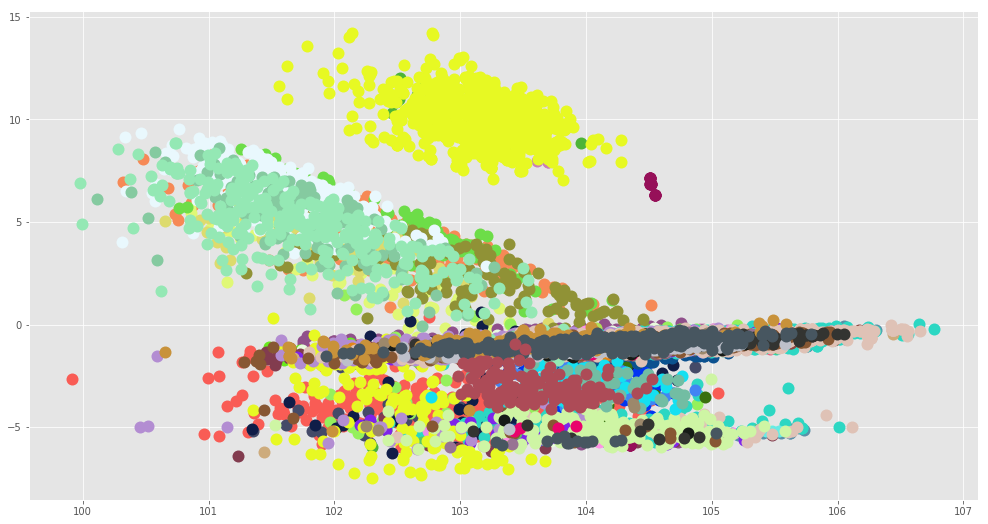

In [111]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.Xplots, group.Yplots, marker='o', linestyle='', ms=12, 
            color=colors_dict[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'Xplots',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'Yplots',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')


    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png')